In [1]:
%pylab inline

import os
import scipy.io
import numpy as np
from keras.models import Sequential
from keras.layers import Convolution2D, Dense, Dropout, Flatten, MaxPooling2D
from keras.utils import np_utils
from keras.optimizers import Adam
from keras.models import load_model




Populating the interactive namespace from numpy and matplotlib


Using TensorFlow backend.


In [2]:
######################### load file - data ####################

#Go to the data directory 
os.chdir('C:\Liliana')
load_data = scipy.io.loadmat('Calcium_signalling_decisions_1000cells.mat')



In [3]:
#Define variables 
total = len(load_data['cell_classified'][0])
print(total)
Int_profile_len = len(load_data['cell_classified'][0,0]['intensity'][0])
print(Int_profile_len)

1000
900


In [4]:
#Matrix for intensity values
data = np.zeros((total,Int_profile_len))
print(data.shape)
for i in range(0,Int_profile_len):
    data[i,:] = load_data['cell_classified'][0,i]['intensity']



(1000, 900)


In [5]:
#Array for the classes 
classes = load_data['cell_classified'][0]['decision'].astype(int)
print(classes.shape)

(1000,)


(990, 900)
(990,)


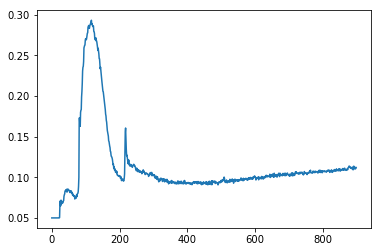

In [6]:
#Elimate intensity profiles with NaN values and corresponding classes
nan_indices = np.where(np.isnan(data))

data = np.delete(data,nan_indices[0], axis = 0)
classes = np.delete(classes,nan_indices[0], axis = 0)

print(data.shape)
print(classes.shape)

#Redefine the total number of data
total = len(data)


plot(data[6])

In [7]:
"""### SCALE THE INTENSITY VALUES
data_scaled = np.zeros((total,Int_profile_len))
for i in range(total):
    data_scaled[i,:] = (data[i,:] - np.mean(data[i,:]))
    data_scaled[i,:] = data_scaled[i,:]/np.std(data_scaled[i,:])

plot(data_scaled[6])""" #GOT NAN

'### SCALE THE INTENSITY VALUES\ndata_scaled = np.zeros((total,Int_profile_len))\nfor i in range(total):\n    data_scaled[i,:] = (data[i,:] - np.mean(data[i,:]))\n    data_scaled[i,:] = data_scaled[i,:]/np.std(data_scaled[i,:])\n\nplot(data_scaled[6])'

data shape (990, 256)


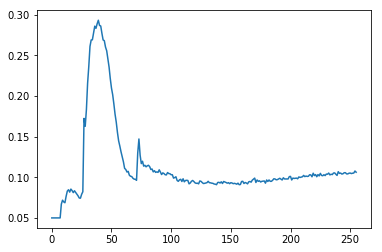

In [8]:
### Downsampling
data1 = data[:,0:768]

step = 3
data_downsampl = data1[:,::step]
print('data shape', data_downsampl.shape)

#Redefine len of the Intensity curves:
Int_profile_len = len(data_downsampl[0])

plot(data_downsampl[6])

In [9]:
#Distribute all values randomly
print('total',total)
randseq = np.random.choice(np.arange(0,total),total,replace=False)

print(randseq.shape)
#Data randomly organized
data_downsampl = data_downsampl[randseq,:]
classes = classes[randseq]

print(classes.shape)
print(data_downsampl.shape)


total 990
(990,)
(990,)
(990, 256)


In [10]:
######################### load file - training data ####################

train_dt = data_downsampl[0:800,:]
train_cl = classes[0:800]

X = train_dt#np.random.rand(10000, 128).astype("float32")
y = train_cl #np.random.randint(3, size=(10000,1))

print('shape y', y.shape)
print('train_dt shape', train_dt.shape)

N_train_cell = len(train_dt)

print('N of training data', N_train_cell)
print('len intensity', Int_profile_len)

# process the data to fit in a keras CNN properly
# input data needs to be (N, C, X, Y) - shaped where
# N - number of samples
# C - number of channels per sample
# (X, Y) - sample size


X = X.reshape((N_train_cell, Int_profile_len,1, 1))
y = np_utils.to_categorical(y)

print(y)


shape y (800,)
train_dt shape (800, 256)
N of training data 800
len intensity 256
[[ 0.  1.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.  0.]
 ..., 
 [ 0.  1.  0.  0.  0.  0.]
 [ 0.  0.  1.  0.  0.  0.]
 [ 0.  0.  0.  0.  1.  0.]]


In [11]:
######################### load file - testing data ####################

#Define variables 
N_test_cell = total - N_train_cell


print('N_test_cell =', N_test_cell)


#Matrix for intensity values
test_dt = np.zeros((N_test_cell,Int_profile_len))

#Use as testing data the last N_test_cell values within the total 
test_dt[:,:]= data_downsampl[N_train_cell:total]

#Same process for the associated classes
test_cl = classes[N_train_cell:total]


print(test_dt.shape)
print(test_cl.shape)


N_test_cell = 190
(190, 256)
(190,)


In [29]:
# define a CNN
# see http://keras.io for API reference

def CNN():
    cnn = Sequential()
    cnn.add(Convolution2D(64, (3, 1),activation="relu",input_shape=(Int_profile_len,1, 1),padding="same"))
    cnn.add(Convolution2D(64, (3, 1), activation="relu", padding="same"))
    cnn.add(MaxPooling2D(pool_size=(2,1)))

    #border_mode = same => output size is the same of input size. The filter does not go outside the bounds of the input
    #ReLU => thresholding at zero. All the negative values will be = 0, values bigger than zero will mantain the same value.
    cnn.add(Convolution2D(128, (3, 1), activation="relu", padding="same"))
    cnn.add(Convolution2D(128, (3, 1), activation="relu", padding="same"))
    cnn.add(Convolution2D(128, (3, 1), activation="relu", padding="same"))
    cnn.add(MaxPooling2D(pool_size=(2,1)))

    cnn.add(Convolution2D(256, (3, 1), activation="relu", padding="same"))
    cnn.add(Convolution2D(256, (3, 1), activation="relu", padding="same"))
    cnn.add(Convolution2D(256, (3, 1), activation="relu", padding="same"))
    cnn.add(MaxPooling2D(pool_size=(2,1)))

    cnn.add(Flatten())
    cnn.add(Dense(1024, activation="relu"))
    cnn.add(Dropout(0.5)) 
    cnn.add(Dense(6, activation="softmax"))

    # define optimizer and objective, compile cnn

    cnn.compile(loss="categorical_crossentropy", optimizer=Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0))
    #default parameters coming from the paper: https://arxiv.org/abs/1412.6980v8
    
    #train
    cnn.fit(X, y, epochs=2, verbose = 2)
    
    #Evaluation code which makes prediction
    out = cnn.predict(test_dt.reshape((N_test_cell, Int_profile_len,1, 1)))
    
    #keras.callbacks.ModelCheckpoint(filepath, monitor='val_loss', verbose=0, save_best_only=False, save_weights_only=False, mode='auto', period=1)
    from keras.models import load_model

    cnn.save('30_05_2017.h5')
    return out

In [30]:
iterations = 1
confidence_array = np.zeros(iterations)
for i in range(iterations):
    print(i)
    out = CNN()
    confidence_array[i] = (float(np.sum(np.argmax(out,1)==test_cl))/float(test_cl.shape[0])*100.0)



print(confidence_array)    

0
Epoch 1/2
27s - loss: 1.4532
Epoch 2/2
24s - loss: 1.1065
[ 55.78947368]


In [19]:
%pylab inline
print(out[0])
print(test_cl[0])

#print(float(np.sum(np.argmax(out,1)==test_cl))/float(test_cl.shape[0])*100.0)

Populating the interactive namespace from numpy and matplotlib
[ 0.00817633  0.4283075   0.30634576  0.01404301  0.23092669  0.01220067]
1


In [ ]:
# Create plots with pre-defined labels.
fig, ax = plt.subplots()
for i in range(0,4):
    if test_cl[i] == 1:
        ax.plot(test_dt[i,:], label='Trig+Sing')
    if test_cl[i] == 2:
        ax.plot(test_dt[i,:], label='Trig+Osc')
    if test_cl[i] == 3:
        ax.plot(test_dt[i,:], label='Trig+Sust')
    if test_cl[i] == 4:
        ax.plot(test_dt[i,:], label='No-Trig')
    if test_cl[i] == 5:
        ax.plot(test_dt[i,:], label='Not Sure')
    legend = plt.legend(loc='upper right', shadow=True, fontsize='x-large')


In [ ]:
"""    if test_cl[i] == 1:
        ax.plot(test_dt[i,:], 'b', label='Trig+Sing')
    if test_cl[i] == 2:
        ax.plot(test_dt[i,:], 'r', label='Trig+Osc')
    if test_cl[i] == 3:
        ax.plot(test_dt[i,:], 'c', label='Trig+Sust')
    if test_cl[i] == 4:
        ax.plot(test_dt[i,:], 'm', label='No-Trig')
    if test_cl[i] == 5:
        ax.plot(test_dt[i,:], 'y', label='Not Sure')"""

In [ ]:
plot(out[:40,0])
plot(out[:40,1])
plot(out[:40,2])

In [31]:
model.load_weights('my_model_weights.h5')

NameError: name 'model' is not defined